# SVM算法

主要是SMO(序列最小化优化算法)的实现

In [1]:
%matplotlib inline

import numpy as np
import random
import math
from matplotlib import pyplot as plt

In [2]:
'''
load dataset
parameter:
    file_path: dataset's path
'''
def load_dataset(file_path):
    context = []
    with open(file_path, 'r') as fp:
        for line in fp.readlines():
            line = line.strip()
            data = [float(ele) for ele in line.split('\t')]
            context.append(data)
            
    context = np.array(context)
    return context[:,:2], context[:, 2].astype(np.int8)

'''
random select second alpha
parameter:
    i: first alpha index
    m: number of alpha
'''
def select_second_alpha(i, m):
    j = i
    while (j == i):
        j = random.uniform(0, m)
    return j

In [29]:
'''
draw raw data
parameter:
    data: raw_data
    labels: labels
'''
def draw_raw_data(data, labels):
    pos_data = data[labels==1, :]
    neg_data = data[labels==-1, :]
    
    plt.scatter(pos_data[:,0], pos_data[:,1], color='g')
    plt.scatter(neg_data[:,0], neg_data[:,1], color='r')

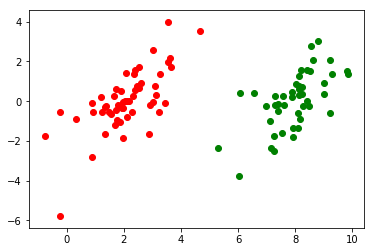

In [13]:
data_file_path = './testSet.txt'
data, labels = load_dataset(data_file_path)
draw_raw_data(data, labels)

## SMO算法（简单版本）

1. 先选择一个$\alpha$，之后再在剩余的$\alpha$中选择另一个组成对
2. 计算Ei和Ej
3. 根据公式更新对应的alpha
4. 随后更新b

在对$\alpha$更新的时候，注意
1. 当$\alpha \in (0, C]$时，样本为正确分类或者支持向量，此时Ei应该很小或者大于0的，所以违反这个的话，要被更新
2. 当$\alpha \in [0, C)$时，样本为错误分类或者支持向量，此时Ei应该很小或者小于0的，所以违反这个的话，要被更新

In [33]:
'''
Kij
parameter:
    v1: vector1
    v2: vector2
'''
def getKij(v1, v2):
    return np.sum(v1*v2)

'''
gxi, this is the hypre planar
parameter:
    data_mat: dataset matrix
    labels: labels array
    alpha: the array of alpha
    b: the model's b
    i: index of the alpha
'''
def gxi(data_mat, labels, alpha, b, i):
    Ki = np.dot(data_mat, data_mat[i, :].T).squeeze()
    return np.sum(alpha * labels * Ki) + b

'''
gxi, this is the hypre planar
parameter:
    data_mat: dataset matrix
    labels: labels array
    alpha: the array of alpha
    b: the model's b
    i: index of the alpha
'''
def SMO_simple(dataset, labels, C, toler, max_iter):
    n, m = dataset.shape
    alpha = np.zeros(n, np.float)
    b = 0
    it = 0
    # loop for enough times
    while (it < max_iter):
        alpha_change = 0
        # outer loop select every alpha
        for i in range(n):
            gx_i = gxi(dataset, labels, alpha, b, i)
            Ei = gx_i - labels[i]
            if all([labels[i]*Ei < -toler, alpha[i] < C]) or \
               all([labels[i]*Ei > toler,  alpha[i] > 0]):
                j = int(select_second_alpha(i, n))
                gx_j = gxi(dataset, labels, alpha, b, j)
                Ej = gx_j - labels[j]
                
                old_alpha_i = alpha[i]
                old_alpha_j = alpha[j]
                
                if labels[i] != labels[j]:
                    L = max(0, alpha[j]-alpha[i])
                    H = min(C, C+alpha[j]-alpha[i])
                else:
                    L = max(0, alpha[i]+alpha[j]-C)
                    H = min(C, alpha[i]+alpha[j])
                
                if L==H:
                    continue
                
                Kii = getKij(dataset[i,:], dataset[i,:])
                Kjj = getKij(dataset[j,:], dataset[j,:])
                Kij = getKij(dataset[i,:], dataset[j,:])
                eta = Kii + Kjj - 2*Kij
                alpha[j] += labels[j]*(Ei-Ej)/eta
                alpha[j] = max(L, alpha[j])
                alpha[j] = min(H, alpha[j])
                
                if abs(alpha[j] - old_alpha_j) < 0.0001:
                    print("j need not change!!!")
                    continue
                # update alpha_i
                alpha[i] += labels[j]*labels[i]*(old_alpha_j - alpha[j])
                
                # update b
                b1 = b - Ei - labels[i]*(alpha[i] - old_alpha_i)*Kii - labels[j]*(alpha[j] - old_alpha_j)*Kij
                b2 = b - Ej - labels[i]*(alpha[i] - old_alpha_i)*Kij - labels[j]*(alpha[j] - old_alpha_j)*Kjj
                
                if all([alpha[i]>0, alpha[i]<C]):
                    b = b1
                elif all([alpha[j]>0, alpha[j]<C]):
                    b = b2
                else:
                    b = (b1+b2)/2
                alpha_change+=1
                print("iter {} i: {} change time {}".format(it, i, alpha_change))
        if alpha_change == 0:
            it += 1
        else:
            it = 0
            
    return alpha, b

In [34]:
alpha, b = SMO_simple(data, labels, 0.6, 0.01, 10)

iter 0 i: 0 change time 1
j need not change!!!
iter 0 i: 10 change time 2
iter 0 i: 23 change time 3
j need not change!!!
j need not change!!!
iter 0 i: 46 change time 4
j need not change!!!
iter 0 i: 69 change time 5
j need not change!!!
j need not change!!!
j need not change!!!
iter 0 i: 23 change time 1
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
iter 0 i: 0 change time 1
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
iter 0 i: 46 change time 2
j need not change!!!
iter 0 i: 8 change time 1
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
iter 0 i: 54 change time 2
j need not change!!!
j need not change!!!
iter 0 i: 97 change time 3
iter 0 i: 8 change time 1
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need n

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
iter 8 i: 17 change time 1
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
j need not change!!!
iter 1 i: 29 change time 1
j need not change!!!
j need not change!!!
j

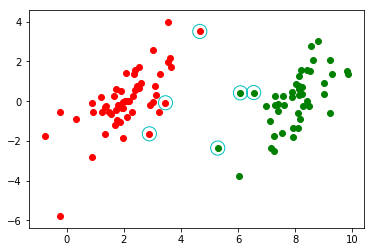

In [39]:
'''
draw support vector
parameter:
    data: all dataset
    labels: all labels
    alpha: SMO's output
    C: loosen parameter
'''
def draw_support_vector(data, labels, alpha, C):
    pos_data = data[labels==1, :]
    neg_data = data[labels==-1, :]
    
    plt.scatter(pos_data[:,0], pos_data[:,1], color='g')
    plt.scatter(neg_data[:,0], neg_data[:,1], color='r')
    
    supports = np.nonzero((alpha>0) * (alpha<C))[0]
    plt.scatter(data[supports, 0], data[supports, 1], color='', edgecolors='c', marker='o', s=200)

draw_support_vector(data, labels, alpha, 0.6)

## 完整版的SMO

在简单版本中，SMO方法通过遍历所有的alpha来形成alpha对，但是实际上，这是可以通过一些策略来加速寻找要优化的alpha对
1. 外层循环找到第一个$\alpha1$，其满足的条件为违反KKT条件
2. 根据$alpha1$得到Ei，之后找到与之距离最大的Ej，得到j
3. 运行更新程序

In [ ]:
'''
structure: store the parameter need to be update
'''
class SMO:
    def __init__(self, data, labels, C, toler):
        self.X = data
        self.y = labels
        self.C = C
        self.toler = toler
        self.n = data.shape[0]
        self.alpha = np.zeros(self.n)
        self.Ecache = np.zeros((self.n, 2))
        
def 